In [2]:

import sys
sys.path.append('..')
from datasets.nuscenes import NuScenesDataset
from utils.filter import *
from glob import glob
import os
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from modules.custom_networks import GenericInjection
import torchmetrics
from utils.filter import EllipseFilter
from glob import glob
from utils.utils import generate_model_from_config
import os
import cv2
from mmdet3d.apis import init_model, inference_detector

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
torch_geometric not installed


In [3]:
# det_model_checkpoint = r'/mnt/ssd2/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth'
det_model_checkpoint = r'/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth'
# det_model_config= r'/mnt/ssd2/mmdetection3d/configs/centerpoint/centerpoint_voxel0075_second_secfpn_head-dcn-circlenms_8xb4-cyclic-20e_nus-3d.py'
det_model_config= r'/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/configs/centerpoint/centerpoint_voxel0075_second_secfpn_head-dcn-circlenms_8xb4-cyclic-20e_nus-3d.py'
det_model = init_model(det_model_config, det_model_checkpoint, device='cuda:0')

Loads checkpoint by local backend from path: /home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/ckpts/centerpoint_0075voxel_second_secfpn_dcn_circlenms_4x8_cyclic_20e_nus_20220810_025930-657f67e0.pth
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.0.feature_adapt_cls is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.0.feature_adapt_reg is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.1.feature_adapt_cls is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.1.feature_adapt_reg is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.2.feature_adapt_cls is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2dPack pts_bbox_head.task_heads.2.feature_adapt_reg is upgraded to version 2.
08/05 15:56:52 - mmengine - INFO - DeformConv2d

In [4]:
dataset_config = {
    'name': 'NuScenesDataset',
    'root_dir': '/media/ssd_reza/nuscenes/',
    'version': 'v1.0-trainval',
    'process': False,
    'filter_labels_only': False,
    'save_path': '/media/wmg-5gcat/Co-op Autonomy 2/Hakan',
    'save_filename': 'nuscenes_train_fix.pkl',
    'filtering_style': 'FilterType.NONE',
    'filter_params': {
      'a': 15,
      'b': 25,
      'offset': -10,
      'axis': 1}}
nus = NuScenesDataset(**dataset_config) 

Filtering style FilterType.NONE
Loading dataset from file
Loaded dataset with 23923 samples, dict_keys(['path', 'label', 'sample_token'])


In [6]:
data = nus[28]
cloud = data.get('pointcloud')
labels = data.get('labels')
print(len(labels))

5


In [12]:
ranges_X = []
for data in nus:
    cloud = data.get('pointcloud')
    # print(np.max(cloud.points, axis=0), np.max(cloud.points, axis=1))
    ranges_X.append(np.max(cloud.points, axis=0) - np.min(cloud.points, axis=0))


In [9]:
x_ranges = np.array(ranges_X)[:, 0]
y_ranges = np.array(ranges_X)[:, 1]


In [68]:
min(x_ranges), min(y_ranges)

(25.326967, 96.61832)

(array([  1.,   1.,   5.,   0.,   7.,  16.,   9.,  11.,  12.,  24.,  25.,
         29.,  41.,  32.,  37.,  36.,  58.,  57.,  55.,  64.,  76.,  78.,
        101., 104.,  82.,  97., 137., 115., 115., 130., 128., 142., 159.,
        182., 186., 208., 265., 200., 280., 224., 227., 218., 252., 255.,
        281., 283., 262., 283., 300., 298., 298., 356., 426., 398., 341.,
        330., 307., 351., 416., 307., 356., 351., 373., 388., 352., 410.,
        445., 442., 411., 540., 468., 472., 535., 460., 507., 454., 460.,
        457., 537., 433., 466., 417., 413., 412., 356., 381., 328., 324.,
        335., 359., 346., 259., 253., 216., 140., 186.,  70.,  46.,  33.,
         14.]),
 array([ 25.32696724,  27.15067863,  28.97439003,  30.79810333,
         32.62181473,  34.44552612,  36.26923752,  38.09294891,
         39.91666031,  41.74037552,  43.56408691,  45.38779831,
         47.2115097 ,  49.0352211 ,  50.8589325 ,  52.68264389,
         54.50635529,  56.33006668,  58.15378189,  59.97749329

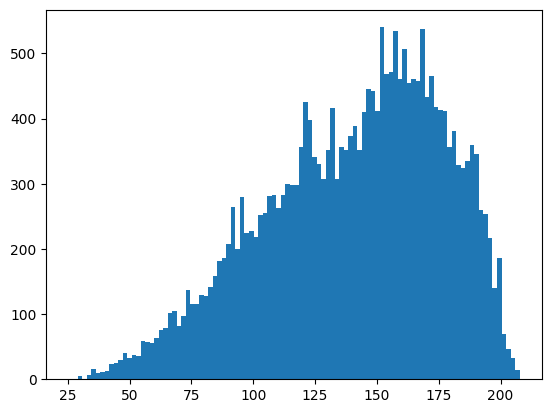

In [10]:
from matplotlib import pyplot as plt
plt.hist(x_ranges, bins=100)

(array([  1.,   0.,   1.,   1.,   1.,   0.,   0.,   2.,   4.,   3.,   3.,
          0.,   8.,   8.,   2.,  12.,   2.,   4.,   2.,   3.,   6.,   4.,
          5.,   2.,  10.,   4.,  16.,   7.,   9.,   7.,   8.,  14.,  14.,
          9.,  17.,  25.,   9.,  25.,  22.,  19.,  25.,  21.,  30.,  37.,
         59.,  57.,  55.,  80.,  57.,  69.,  94.,  90., 113., 104., 115.,
        166., 173., 176., 216., 221., 229., 227., 294., 281., 273., 294.,
        290., 378., 427., 459., 538., 555., 591., 572., 668., 666., 772.,
        767., 759., 777., 811., 927., 834., 886., 809., 887., 818., 735.,
        744., 665., 610., 644., 558., 510., 474., 379., 321., 137.,  83.,
         27.]),
 array([ 96.61831665,  97.74959564,  98.88087463, 100.01215363,
        101.14343262, 102.27471161, 103.4059906 , 104.53726959,
        105.66854858, 106.79982758, 107.93110657, 109.06238556,
        110.19366455, 111.32494354, 112.45622253, 113.58750153,
        114.71878052, 115.85005951, 116.9813385 , 118.11261749

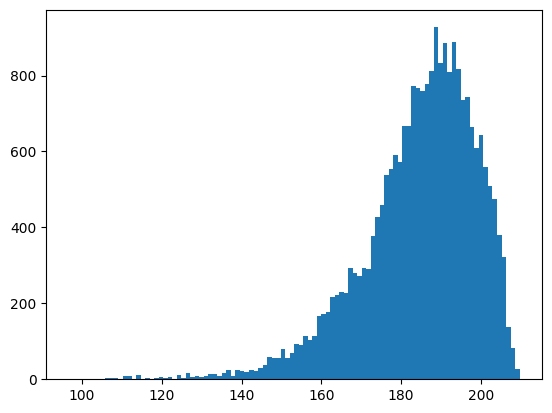

In [12]:
plt.hist(y_ranges,bins=100)

(array([1.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 1.100e+01, 1.800e+01,
        1.900e+01, 5.700e+01, 7.600e+01, 1.160e+02, 1.640e+02, 1.920e+02,
        3.050e+02, 3.480e+02, 4.090e+02, 4.830e+02, 6.100e+02, 6.610e+02,
        8.210e+02, 8.380e+02, 9.370e+02, 9.130e+02, 1.012e+03, 1.005e+03,
        9.240e+02, 1.024e+03, 8.920e+02, 8.350e+02, 8.400e+02, 8.120e+02,
        6.950e+02, 6.820e+02, 6.990e+02, 6.450e+02, 6.780e+02, 5.550e+02,
        5.020e+02, 5.320e+02, 4.720e+02, 3.600e+02, 3.240e+02, 2.800e+02,
        2.580e+02, 2.570e+02, 2.460e+02, 1.870e+02, 1.790e+02, 3.010e+02,
        1.280e+02, 1.440e+02, 1.270e+02, 1.350e+02, 1.190e+02, 8.600e+01,
        1.690e+02, 6.000e+01, 7.500e+01, 5.700e+01, 5.800e+01, 4.500e+01,
        4.400e+01, 3.800e+01, 6.700e+01, 5.800e+01, 8.900e+01, 3.800e+01,
        2.200e+01, 1.700e+01, 1.300e+01, 1.300e+01, 1.800e+01, 8.000e+00,
        6.000e+00, 8.000e+00, 6.000e+00, 8.000e+00, 6.000e+00, 7.000e+00,
        4.000e+00, 7.000e+00, 5.000e+0

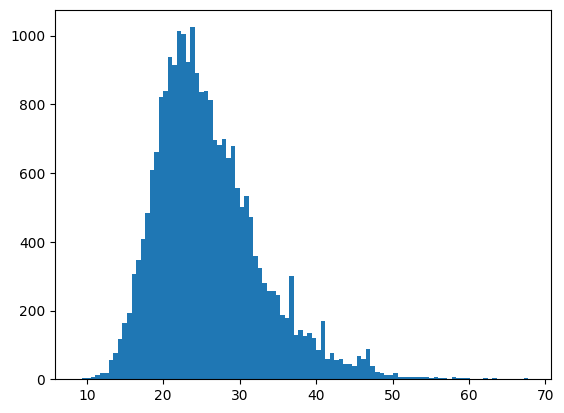

In [13]:
z_ranges = np.array(ranges_X)[:, 2]
plt.hist(z_ranges, bins=100)

In [6]:
sample_data = nus[1000]
cloud = sample_data.get('pointcloud').points
labels = sample_data.get('labels')
cloud.shape

(34752, 5)

In [7]:
#Filter any x value > 100 and < -100, same for y
print(max(cloud[:, 0]), min(cloud[:, 0]))
th = 75
ncloud = cloud[(cloud[:, 0] < th) & (cloud[:, 0] > -th) & (cloud[:, 1] < th) & (cloud[:, 1] > -th)]
ncloud.shape

86.32841 -21.688875


(34683, 5)

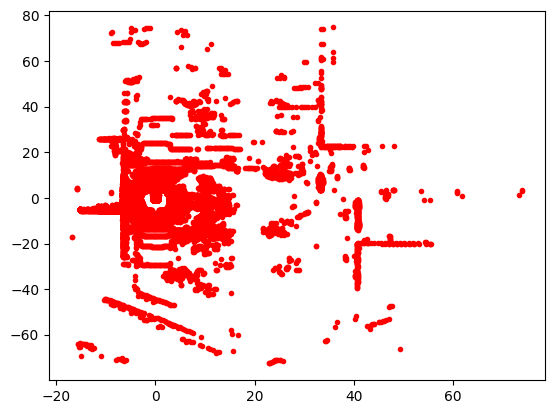

In [14]:
plt.plot(ncloud[:, 0], ncloud[:, 1], 'r.')

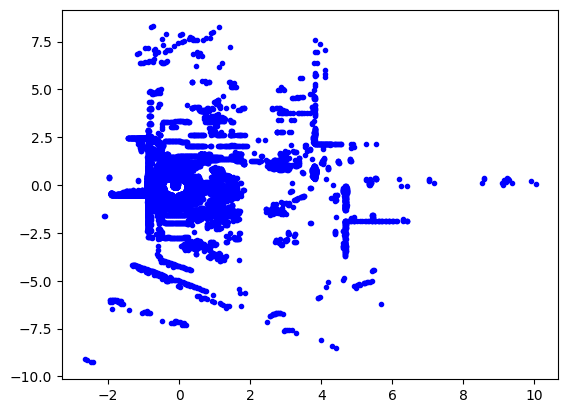

In [43]:
#Normalize the ncloud
mean_coords = np.mean(ncloud, axis=0)
std_coords = np.std(ncloud, axis=0)
ncloud = (ncloud - mean_coords) / std_coords
plt.plot(ncloud[:, 0], ncloud[:, 1], 'b.')

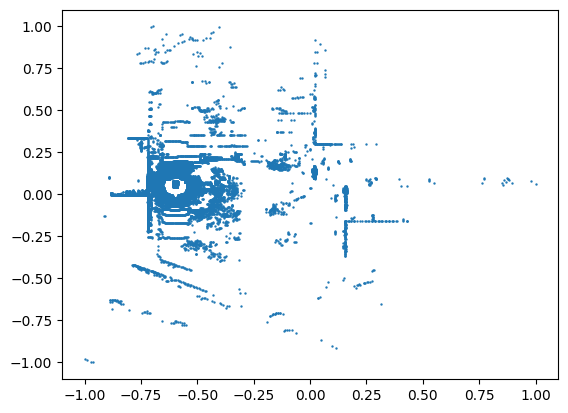

In [105]:
#Normalize the ncloud between -1,1
ncloud = (ncloud - np.min(ncloud, axis=0)) / (np.max(ncloud, axis=0) - np.min(ncloud, axis=0)) * 2 - 1
plt.scatter(ncloud[:, 0], ncloud[:, 1],s=0.5)

(-75.0, 75.0)

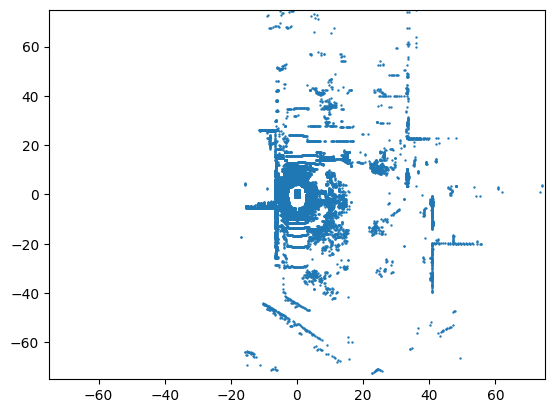

In [8]:
# ncloud = ncloud/100
plt.scatter(ncloud[:, 0], ncloud[:, 1],s=0.5)
plt.xlim(-th, th)
plt.ylim(-th, th)

In [92]:
print(ncloud)

[[-3.0883231e-14 -2.2609086e-15 -1.8393534e-14  3.1999999e-13
   0.0000000e+00]
 [-3.0902113e-14 -2.2500047e-15 -1.7441110e-14  2.6999998e-13
   9.9999998e-15]
 [-3.1385105e-14 -2.2433613e-15 -1.6766314e-14  1.7000000e-13
   2.0000000e-14]
 ...
 [-6.1693665e-14 -5.3822528e-17  8.6704842e-15  2.0000000e-14
   2.9000001e-13]
 [-5.8831270e-14 -3.0798283e-17  9.6656276e-15  2.1999999e-13
   2.9999999e-13]
 [-6.4151294e-14 -1.1182653e-17  1.2086729e-14  1.4999999e-13
   3.0999996e-13]]


(array([3.9800e+02, 1.4553e+04, 1.7462e+04, 8.8900e+02, 5.1000e+02,
        8.3100e+02, 8.3000e+01, 1.2000e+01, 3.0000e+00, 1.1000e+01]),
 array([-2.16888748e-05, -1.08871463e-05, -8.54182858e-08,  1.07163096e-05,
         2.15180389e-05,  3.23197673e-05,  4.31214939e-05,  5.39232242e-05,
         6.47249544e-05,  7.55266810e-05,  8.63284076e-05]),
 <BarContainer object of 10 artists>)

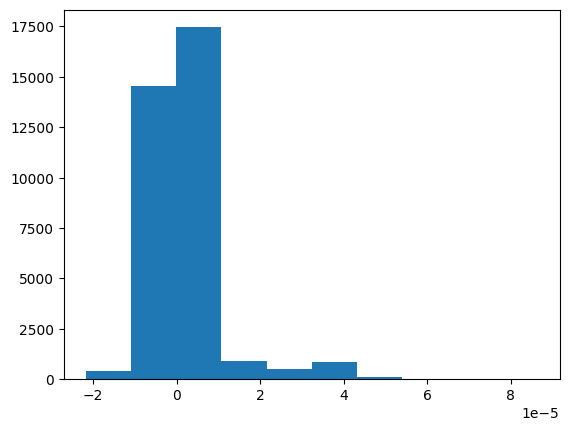

In [80]:
plt.hist(ncloud[:,0])

(150, 150)


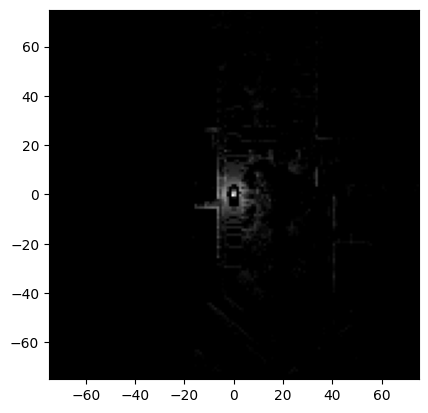

In [10]:
min_x = np.min(ncloud[:, 0])
max_x = np.max(ncloud[:, 0])
min_y = np.min(ncloud[:, 1])
max_y = np.max(ncloud[:, 1])
grid_x = th*2
grid_y = th*2
factor = 0.1
x = np.linspace(-th, th, grid_x+1)
y = np.linspace(-th, th, grid_y+1)
density_map, _, _ = np.histogram2d(ncloud[:, 1], ncloud[:, 0], bins=[x, y])
import matplotlib.pyplot as plt
normalized_density_map = np.log1p(density_map*factor)
print(normalized_density_map.shape)
plt.imshow(normalized_density_map, origin='lower', cmap='gray',
           extent=[-th, th, -th, th])
# plt.colorbar(label='Point Density')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Point Density Map')
# plt.show()
# plt.hist(normalized_density_map)
# for point in ncloud:
#     x = point[0]
#     y = point[1]
#     x_idx = np.argmin(np.abs(x - xx[0]))
#     y_idx = np.argmin(np.abs(y - yy[:, 0]))
#     xx[y_idx, x_idx] = 1

(150, 150)


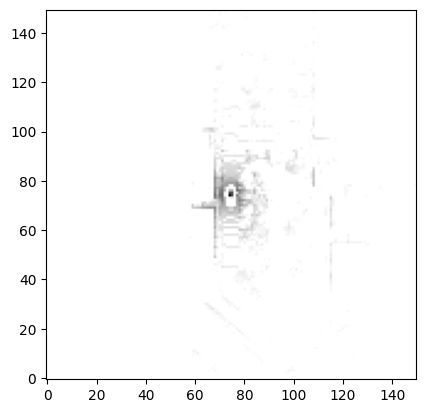

In [83]:
plt.imshow(1-normalized_density_map.T, origin='lower', cmap='gray',)
mask1 = 1-normalized_density_map.T
print(mask1.shape)

In [7]:
res = inference_detector(det_model, cloud)

AttributeError: 'PointCloud' object has no attribute 'shape'

In [85]:
labels = sample_data.get('labels')

rdata = res[0].pred_instances_3d
boxes = rdata.bboxes_3d.tensor.cpu().numpy()
scores = rdata.scores_3d.cpu().numpy()
# labels = rdata.labels_3d.cpu().numpy()
# print(labels.shape)
filtered_boxes = boxes[scores > 0.5]


In [86]:
labels[0].get

In [98]:
from utils.utils import check_detection_matches
from utils.boundingbox import BoundingBox
filtered_c_boxes = [BoundingBox(box[:3], box[3:6], box[6]) for box in filtered_boxes]
match_data =check_detection_matches(labels, filtered_c_boxes, 0.5)

In [97]:
match_data

([],
  <utils.boundingbox.BoundingBox at 0x7fe2563e2c70>])

In [11]:
print(normalized_density_map.shape
      )

(150, 150)


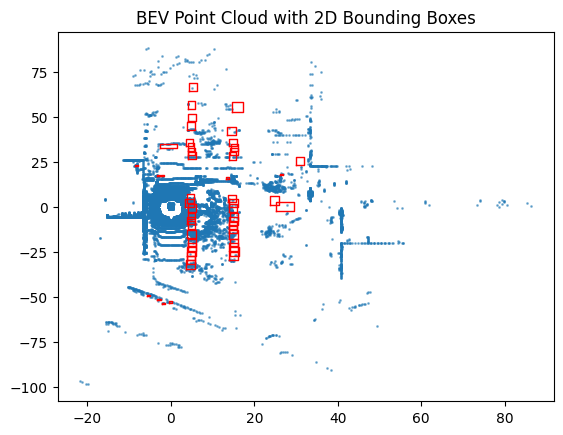

In [25]:
gt_bev_boxes = []
for box in labels:
    corners = box.center
    x,y,z =box.center
    dx, dy, dz = box.dimensions
    theta = box.rotation
    theta = np.arctan2(theta[1, 0], theta[0, 0])

    center = np.array([x, y])
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])

    # Compute the corners of the bounding box in local frame before rotation
    local_corners = np.array([
        [dx / 2, dy / 2],
        [dx / 2, -dy / 2],
        [-dx / 2, -dy / 2],
        [-dx / 2, dy / 2]
    ])

    # Rotate the corners and translate to the center
    rotated_corners = np.dot(local_corners, rotation_matrix) + center

    # Extract the minimum and maximum values to define the 2D bounding box
    min_corner = np.min(rotated_corners, axis=0)
    max_corner = np.max(rotated_corners, axis=0)

    # Define the BEV bounding box as [x_min, y_min, x_max, y_max]
    bev_box = [min_corner[0], min_corner[1], max_corner[0], max_corner[1]]
    gt_bev_boxes.append(bev_box)  
plt.scatter(cloud[:, 0], cloud[:, 1], s=1,alpha=0.5)
for box in gt_bev_boxes:
    min_x, min_y, max_x, max_y = box
    plt.plot([min_x, max_x, max_x, min_x, min_x],
                [min_y, min_y, max_y, max_y, min_y],
                color='red', linewidth=1)

# Plot details
plt.xlabel('')
plt.ylabel('')
# plt.xlim(-10, 50)
# plt.ylim(-60, 100)
plt.title('BEV Point Cloud with 2D Bounding Boxes')
# 
# plt.axis('equal')
plt.grid(False)
plt.show()

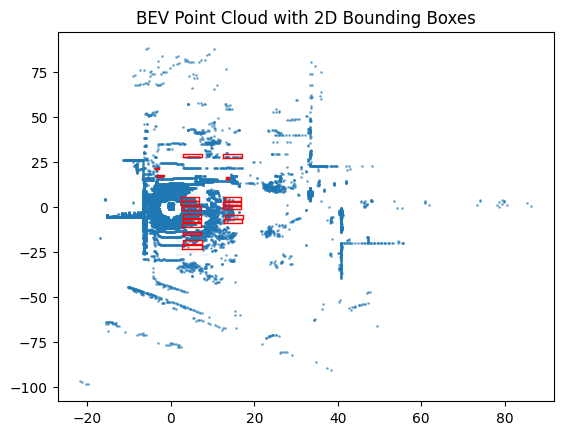

In [26]:
bev_boxes = []
for box in filtered_boxes:
    x = box[0]
    y = box[1]
    z = box[2]
    dx = box[3]
    dy = box[4]
    dz = box[5]
    theta = box[6]
    center = np.array([x, y])
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([
        [cos_theta, -sin_theta],
        [sin_theta, cos_theta]
    ])

    # Compute the corners of the bounding box in local frame before rotation
    local_corners = np.array([
        [dx / 2, dy / 2],
        [dx / 2, -dy / 2],
        [-dx / 2, -dy / 2],
        [-dx / 2, dy / 2]
    ])

    # Rotate the corners and translate to the center
    rotated_corners = np.dot(local_corners, rotation_matrix) + center

    # Extract the minimum and maximum values to define the 2D bounding box
    min_corner = np.min(rotated_corners, axis=0)
    max_corner = np.max(rotated_corners, axis=0)

    # Define the BEV bounding box as [x_min, y_min, x_max, y_max]
    bev_box = [min_corner[0], min_corner[1], max_corner[0], max_corner[1]]
    bev_boxes.append(bev_box)   
plt.scatter(cloud[:, 0], cloud[:, 1], s=1, alpha=0.5, label='Point Cloud')
# Plot each BEV bounding box
for box in bev_boxes:
    min_x, min_y, max_x, max_y = box
    plt.plot([min_x, max_x, max_x, min_x, min_x],
             [min_y, min_y, max_y, max_y, min_y],
             color='red', linewidth=1)

# Plot details
plt.xlabel('')
plt.ylabel('')
# plt.xlim(-100, 100)
# plt.ylim(-100, 100)
plt.title('BEV Point Cloud with 2D Bounding Boxes')
# 
# plt.axis('equal')
plt.grid(False)
plt.show()

77 78 81 80
77 75 81 78
77 66 82 68
77 63 82 66
78 68 82 70
87 78 91 80
77 54 82 56
87 75 91 77
77 73 82 75
77 59 82 61
77 102 82 104
87 73 91 75
87 66 91 68
87 68 92 70
77 51 82 53
87 102 92 104
72 91 73 92
71 95 72 96
71 91 72 92
88 90 88 91


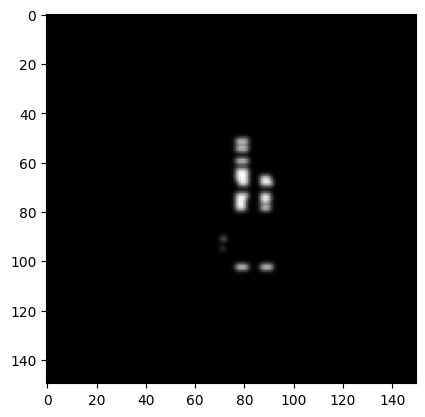

In [62]:
test_img = np.zeros((2*th,2*th,1))
for box in bev_boxes:
    min_x, min_y, max_x, max_y = box
    min_x = int((min_x + th))
    min_y = int((min_y + th))
    max_x = int((max_x + th))
    max_y = int((max_y + th))
    print(min_x, min_y, max_x, max_y)
    test_img[min_y:max_y, min_x:max_x] = 1
#Apply gaussian filter
import scipy.ndimage
test_img2 = scipy.ndimage.gaussian_filter(test_img, sigma=1)
plt.imshow(test_img2, cmap='gray')
plt.show()

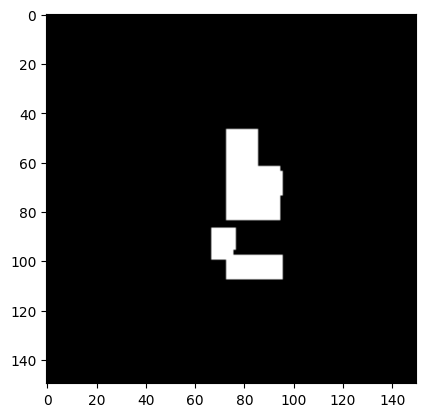

In [63]:
#Make any nonzero pixel 1 and rest 0
test_img2[test_img2 > 0] = 1
plt.imshow(test_img2, cmap='gray')

In [12]:
test_map = normalized_density_map

(array([2.1061e+04, 3.2600e+02, 1.8500e+02, 1.3600e+02, 0.0000e+00,
        1.0600e+02, 7.0000e+01, 5.4000e+01, 9.9000e+01, 2.7000e+01,
        2.4000e+01, 5.1000e+01, 2.0000e+01, 4.2000e+01, 2.3000e+01,
        2.5000e+01, 2.0000e+01, 1.1000e+01, 2.3000e+01, 1.3000e+01,
        5.0000e+00, 1.4000e+01, 1.2000e+01, 1.1000e+01, 1.3000e+01,
        5.0000e+00, 6.0000e+00, 1.3000e+01, 6.0000e+00, 8.0000e+00,
        1.0000e+01, 4.0000e+00, 3.0000e+00, 7.0000e+00, 4.0000e+00,
        5.0000e+00, 4.0000e+00, 4.0000e+00, 6.0000e+00, 2.0000e+00,
        2.0000e+00, 4.0000e+00, 5.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

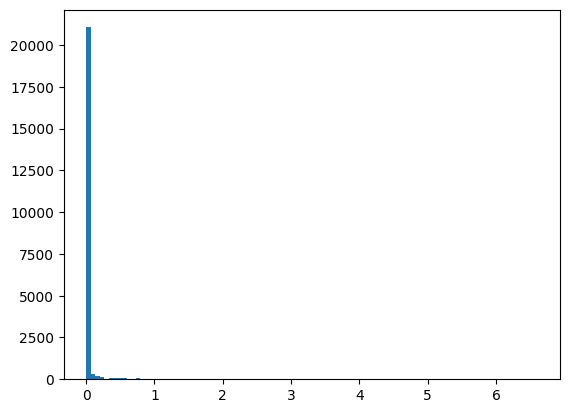

In [13]:
plt.hist(test_map.flatten(), bins=100)

(150, 150)


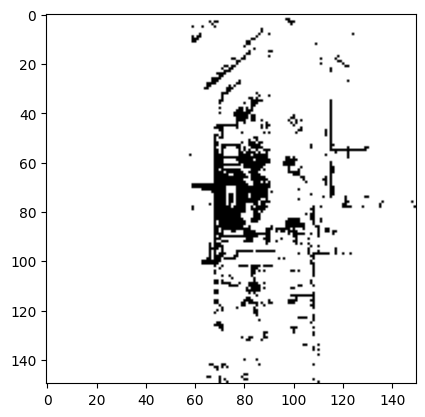

In [19]:
print(normalized_density_map.shape)
plt.imshow(1-normalized_density_map, cmap='gray')
# plt.xlim(-th, th)
# plt.ylim(-th, th)

(array([3.8033e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2700e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8600e+02, 0.0000e+00,
        0.0000e+00, 1.9300e+02, 0.0000e+00, 1.2200e+02, 0.0000e+00,
        9.4000e+01, 8.1000e+01, 0.0000e+00, 5.2000e+01, 5.7000e+01,
        5.2000e+01, 4.1000e+01, 3.4000e+01, 3.0000e+01, 2.3000e+01,
        1.9000e+01, 4.1000e+01, 2.4000e+01, 2.8000e+01, 2.0000e+01,
        2.4000e+01, 1.2000e+01, 1.6000e+01, 1.6000e+01, 1.1000e+01,
        6.0000e+00, 1.3000e+01, 1.3000e+01, 7.0000e+00, 1.4000e+01,
        1.1000e+01, 8.0000e+00, 1.0000e+01, 1.0000e+01, 7.0000e+00,
        5.0000e+00, 4.0000e+00, 7.0000e+00, 4.0000e+00, 6.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 7.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

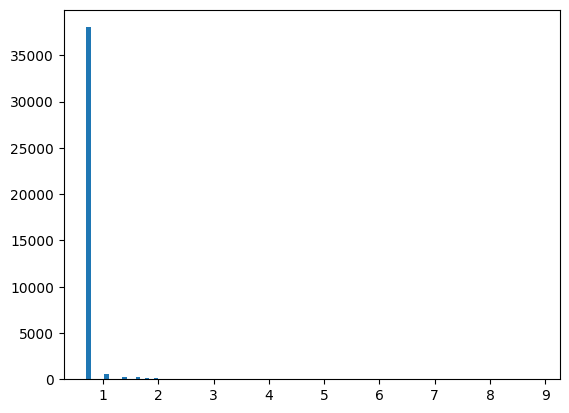

In [42]:
plt.hist(normalized_density_map.flatten(),bins=100)

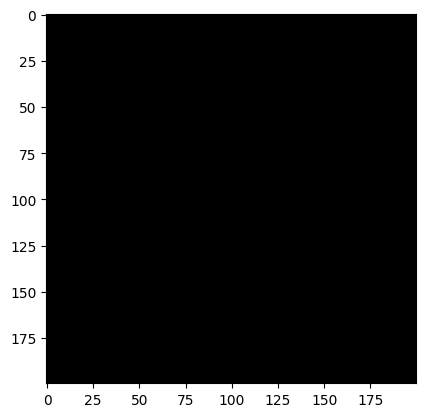

In [54]:
normalized_density_map[normalized_density_map > 0.00000001] = 1
plt.imshow(normalized_density_map, cmap='gray')

In [5]:
activation_list = []
def register_activation_output(module, input, output):
    # print(output[0].shape,output[1].shape)
    # print(len(output))
    last_output = output.detach().cpu().numpy() #TODO: generalize this
    # print("Last output shape",last_output.shape)
    # print(last_output.shape)
    # print("-------------------")
    last_output = np.squeeze(last_output)
    activation_list.append(last_output)

def register_activation_input(module, input, output):
    # print(output[0].shape,output[1].shape)
    last_output = input[0].detach().cpu().numpy() #TODO: generalize this
    # print("Last output shape",last_output.shape)
    last_output = np.squeeze(last_output)
    activation_list.append(last_output)

In [6]:
h1 = det_model.pts_backbone.blocks._modules['0'].register_forward_hook(register_activation_input)
h2 = det_model.pts_backbone.blocks._modules['1'].register_forward_hook(register_activation_input)
h3 = det_model.pts_backbone.blocks._modules['1'].register_forward_hook(register_activation_output)

In [28]:
activation_list = []
inference_detector(det_model, cloud.points)

/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


(<Det3DDataSample(
 
     META INFORMATION
     box_type_3d: <class 'mmdet3d.structures.bbox_3d.lidar_box3d.LiDARInstance3DBoxes'>
     axis_align_matrix: array([[1., 0., 0., 0.],
                [0., 1., 0., 0.],
                [0., 0., 1., 0.],
                [0., 0., 0., 1.]])
     pcd_rotation: tensor([[1., 0., 0.],
                 [-0., 1., 0.],
                 [0., 0., 1.]])
     pcd_rotation_angle: 0.0
     pcd_trans: array([0., 0., 0.])
     transformation_3d_flow: ['R', 'S', 'T']
     flip: False
     pcd_scale_factor: 1.0
     pcd_horizontal_flip: False
     pcd_vertical_flip: False
     box_mode_3d: <Box3DMode.LIDAR: 0>
 
     DATA FIELDS
     eval_ann_info: None
     gt_instances: <InstanceData(
         
             META INFORMATION
         
             DATA FIELDS
         ) at 0x7fd3b86173a0>
     gt_pts_seg: <PointData(
         
             META INFORMATION
         
             DATA FIELDS
         ) at 0x7fd3b8617a90>
     gt_instances_3d: <InstanceData(
   

In [36]:
cloud_tensor = torch.from_numpy(cloud.points).unsqueeze(0).to('cuda:0')


/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(
/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


In [45]:
from tqdm.auto import tqdm
e_sp = []
m_sp = []
l_sp = []
def calculate_sparsity():
    early = activation_list[0]
    mid = activation_list[1]
    late = activation_list[2]
    #Calculate number of zeros 
    early_zeros = np.sum(early==0)
    mid_zeros = np.sum(mid==0)
    late_zeros = np.sum(late==0)
    #number of units in layers 
    early_units = np.prod(early.shape)
    mid_units = np.prod(mid.shape)
    late_units = np.prod(late.shape)
    #calculate sparsity
    early_sparsity = early_zeros/early_units
    mid_sparsity = mid_zeros/mid_units
    late_sparsity = late_zeros/late_units
    e_sp.append(early_sparsity)
    m_sp.append(mid_sparsity)
    l_sp.append(late_sparsity)
length = len(nus)
with tqdm(total=length) as pbar:
    for i in range(length):
        data = nus[i]
        cloud = data.get('pointcloud')
        labels = data.get('labels')
        with torch.no_grad():
            result = inference_detector(det_model,cloud.points)
        calculate_sparsity()
        pbar.update(1)
        activation_list = []

  0%|          | 0/23923 [00:00<?, ?it/s]

/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/models/task_modules/coders/centerpoint_bbox_coders.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.post_center_range = torch.tensor(


KeyboardInterrupt: 

In [15]:
len(activation_list)

3

In [16]:
early = activation_list[0]
mid = activation_list[1]
late = activation_list[2]

In [29]:
#Calculate number of zeros 
early_zeros = np.sum(early==0)
mid_zeros = np.sum(mid==0)
late_zeros = np.sum(late==0)
#number of units in layers 
early_units = np.prod(early.shape)
mid_units = np.prod(mid.shape)
late_units = np.prod(late.shape)
#calculate sparsity
early_sparsity = early_zeros/early_units
mid_sparsity = mid_zeros/mid_units
late_sparsity = late_zeros/late_units
print("Early Sparsity: ",early_sparsity)
print("Mid Sparsity: ",mid_sparsity)
print("Late Sparsity: ",late_sparsity)

Early Sparsity:  0.9896665219907408
Mid Sparsity:  0.6179844232253087
Late Sparsity:  0.7443084490740741


In [18]:
#Convert early to sparse tensor
early_tensor = torch.from_numpy(early).to('cuda:0')
sparse_early= early_tensor.to_sparse()
mid_tensor = torch.from_numpy(mid).to('cuda:0')
mid_early= mid_tensor.to_sparse()
late_tensor = torch.from_numpy(late).to('cuda:0')
late_early= late_tensor.to_sparse()

In [25]:
#Convert early to sparse tensor
print(early.shape)
early_tensor = torch.from_numpy(early).to('cuda:0')
sparse_early= early_tensor.to_sparse_csr()
mid_tensor = torch.from_numpy(mid).to('cuda:0')
mid_early= mid_tensor.to_sparse_csr()
late_tensor = torch.from_numpy(late).to('cuda:0')
late_early= late_tensor.to_sparse_csr()

(256, 180, 180)


RuntimeError: Expect the same number of specified elements per batch.

In [20]:
torch.save(early_tensor,'early_tensor.pth')
torch.save(mid_tensor,'mid_tensor.pth')
torch.save(late_tensor,'late_tensor.pth')
torch.save(sparse_early,'sparse_early.pth')
torch.save(mid_early,'mid_early.pth')
torch.save(late_early,'late_early.pth')


In [26]:
torch.save([sparse_early,mid_tensor,late_tensor], 'sparse_early_mid_late_tensors.pth')

In [32]:
data.get('file_name')

'/mnt/ssd2/nuscenes/samples/LIDAR_TOP/n015-2018-07-27-11-36-48+0800__LIDAR_TOP__1532662710449126.pcd.bin'

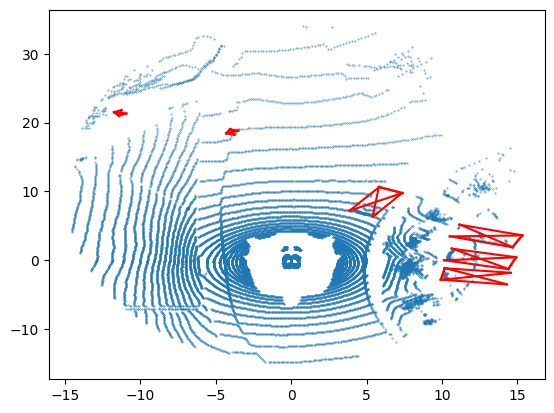

In [33]:
#top view plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(cloud.points[:,0], cloud.points[:,1], s=0.1)
#plot boxes top view
for label in labels:
    box = label.corners
    top_corners = box[:, :2]  # Extracting the top view (XY plane)
    
    # Create a loop to connect the corners of the bounding box
    for i in range(4):
        start = top_corners[i]
        end = top_corners[(i + 1) % 4]
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r')

    # Connect the top and bottom faces of the bounding box
    for i in range(4, 8):
        start = top_corners[i - 4]
        end = top_corners[(i + 1) % 4 + 4]
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r')
plt.show()

In [7]:
myObj_Filter=  ObjectFilter()

In [8]:
cloud

In [34]:
res = myObj_Filter.filter_pointcloud(data=cloud,bounding_boxes=labels)

In [35]:
res.shape

(27332, 5)

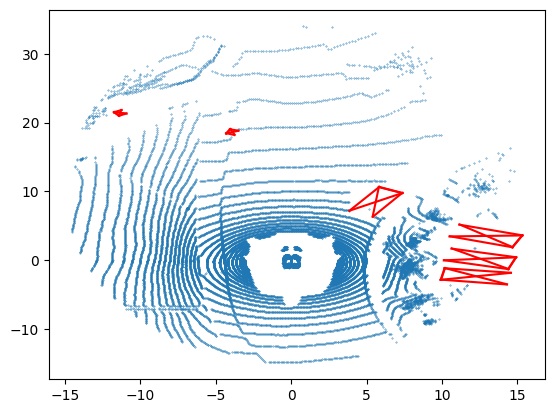

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(res[:,0], res[:,1], s=0.1)
for label in labels:
    box = label.corners
    top_corners = box[:, :2]  # Extracting the top view (XY plane)
    
    # Create a loop to connect the corners of the bounding box
    for i in range(4):
        start = top_corners[i]
        end = top_corners[(i + 1) % 4]
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r')

    # Connect the top and bottom faces of the bounding box
    for i in range(4, 8):
        start = top_corners[i - 4]
        end = top_corners[(i + 1) % 4 + 4]
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r')
plt.show()

In [1]:
import cv2
import numpy as np


: 